# Drought Prediction

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Timeseries Data

## Data Wrangling

#### Reading the input data

In [2]:
drought_df_train = pd.read_csv('data/train_timeseries.csv')
drought_df_test = pd.read_csv('data/test_timeseries.csv')
drought_df_test = pd.read_csv('data/validation_timeseries.csv')

drought_df = pd.concat([drought_df_train, drought_df_test, drought_df_test], axis=0)
drought_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


#### Initial exploration 

In [3]:
drought_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23838360 entries, 0 to 2268839
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.9+ GB


In [4]:
drought_df.isnull().sum()

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          20435100
dtype: int64

#### Removing missing values

In [5]:
# Removing the null values in the target variable as the drought score is only available for once in 7 days.
drought_df = drought_df.dropna()
drought_df.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

#### Format Data

In [11]:
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int32
year             int32
month            int32
day              int32
dtype: object

In [12]:
drought_df['year'] = pd.DatetimeIndex(drought_df['date']).year
drought_df['month'] = pd.DatetimeIndex(drought_df['date']).month 
drought_df['day'] = pd.DatetimeIndex(drought_df['date']).day
drought_df['score'] = drought_df['score'].round().astype(int)
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int32
year             int32
month            int32
day              int32
dtype: object

In [13]:
drought_df['fips'].nunique()

3108

In [9]:
drought_df['score'].round().value_counts()

score
0    2093262
1     579722
2     352327
3     221470
4     115419
5      41060
Name: count, dtype: int64

## EDA

In [14]:
drought_df.columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score', 'year', 'month', 'day'],
      dtype='object')

#### Distribution of continuous variables

In [15]:
measures = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = drought_df[measures]

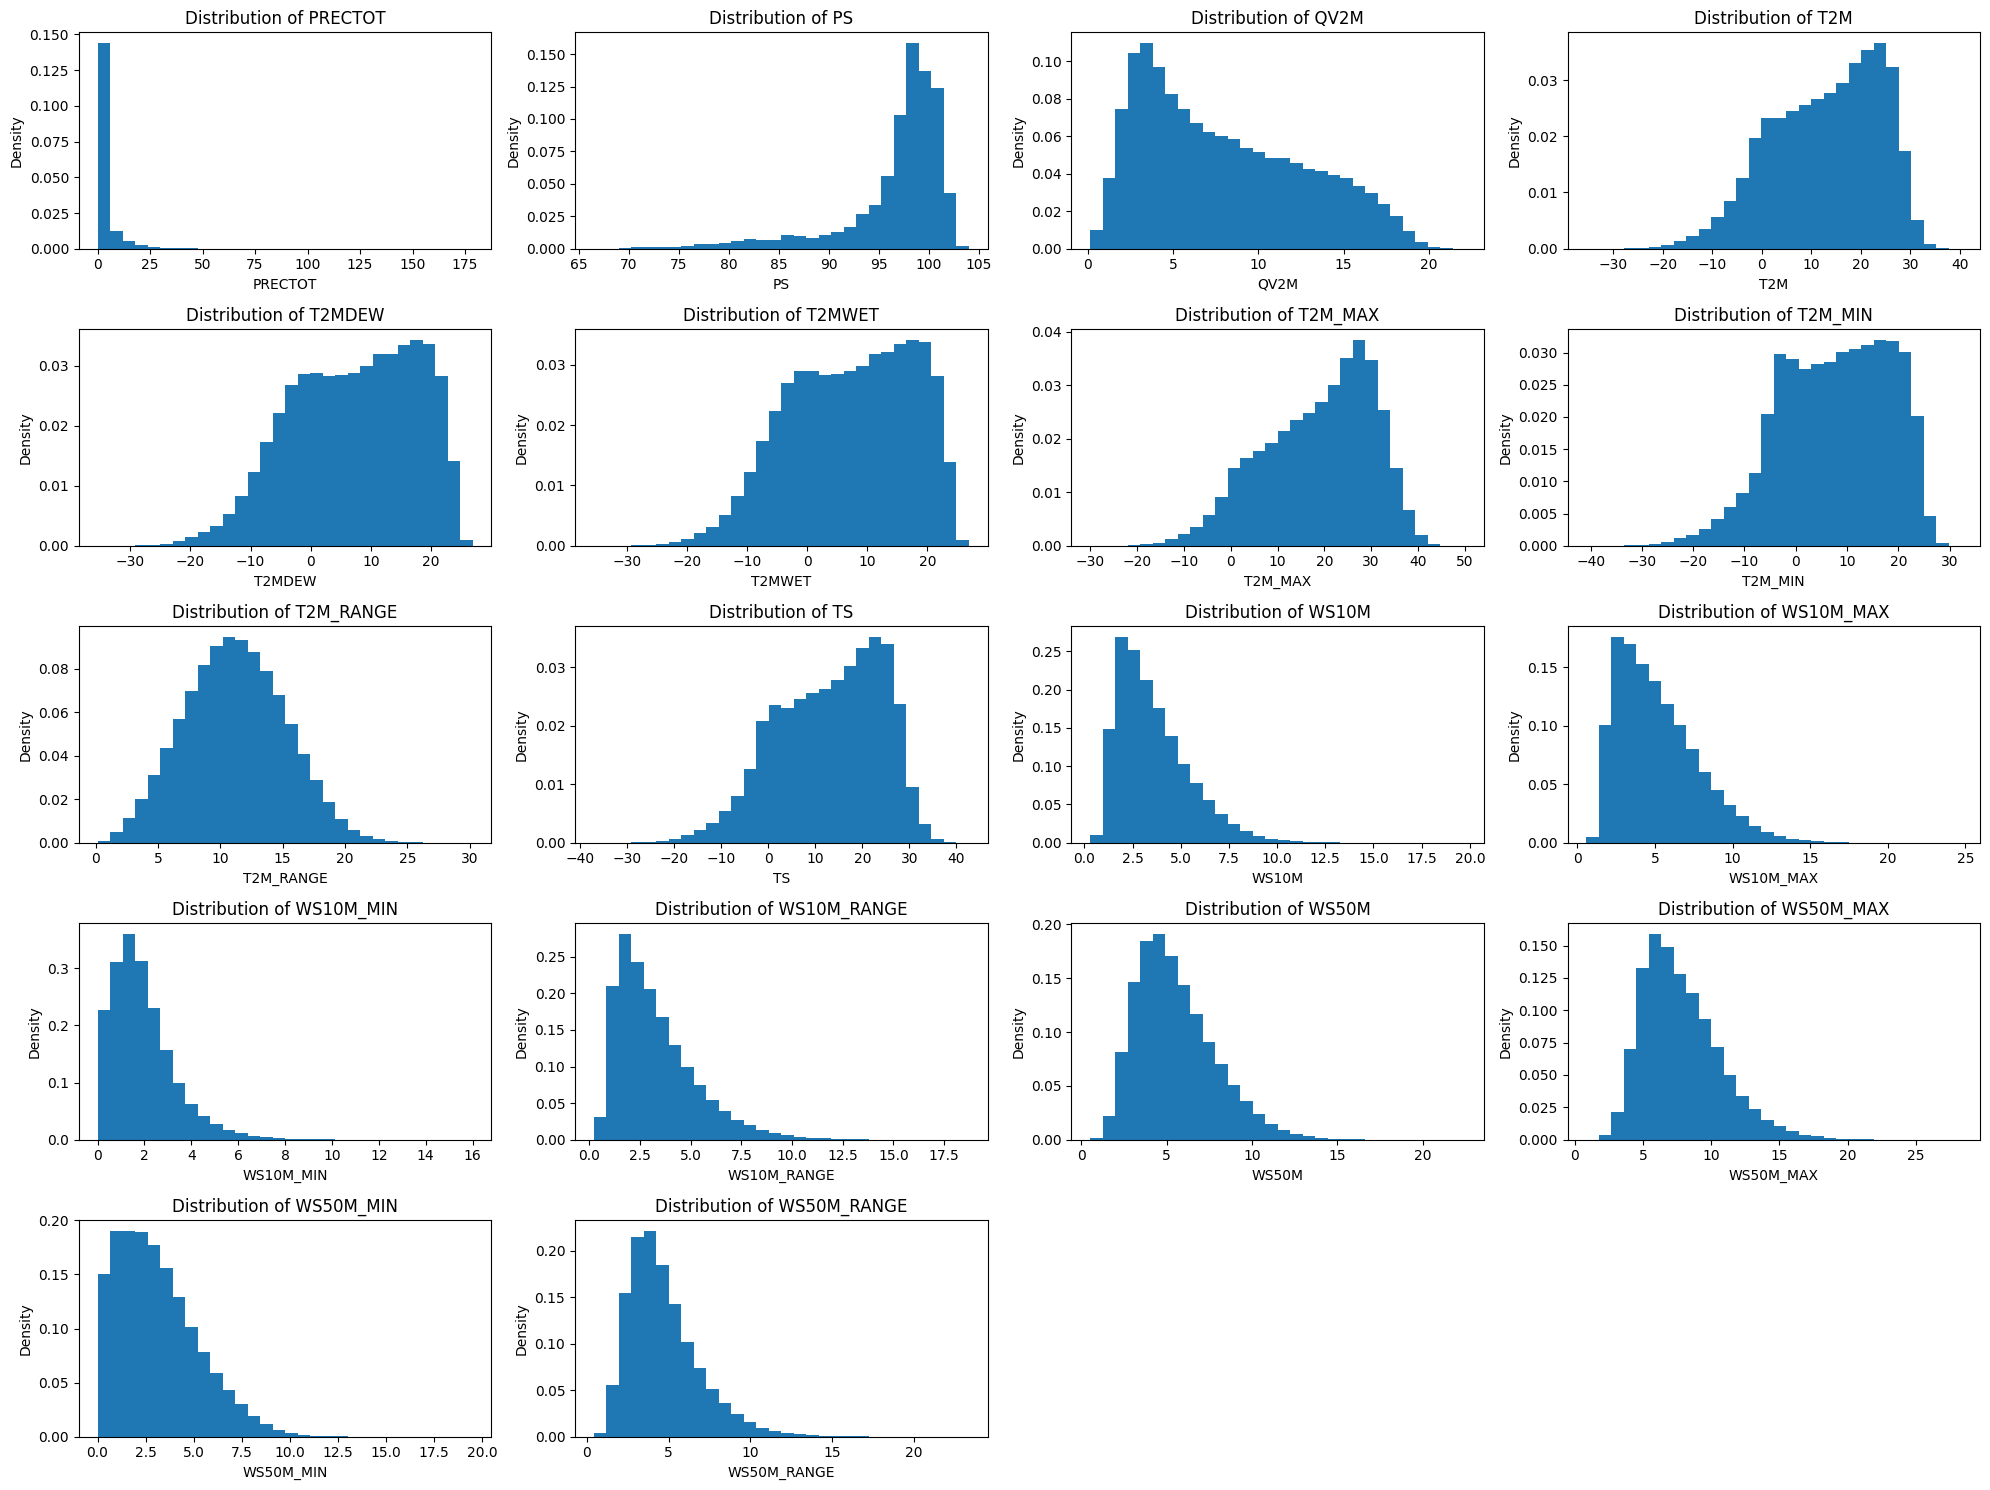

In [16]:
# Calculate number of rows and columns needed
n_measures = len(measures)
n_cols = 4  # Number of columns
n_rows = (n_measures + n_cols - 1) // n_cols  # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot histograms 
for ax, col_name in zip(axes, measures):
    ax.hist(drought_df_measures[col_name], bins=30, density=True)  
    ax.set_xlabel(col_name)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {col_name}')

# Remove any empty subplots
for i in range(len(measures), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Identifying outliers

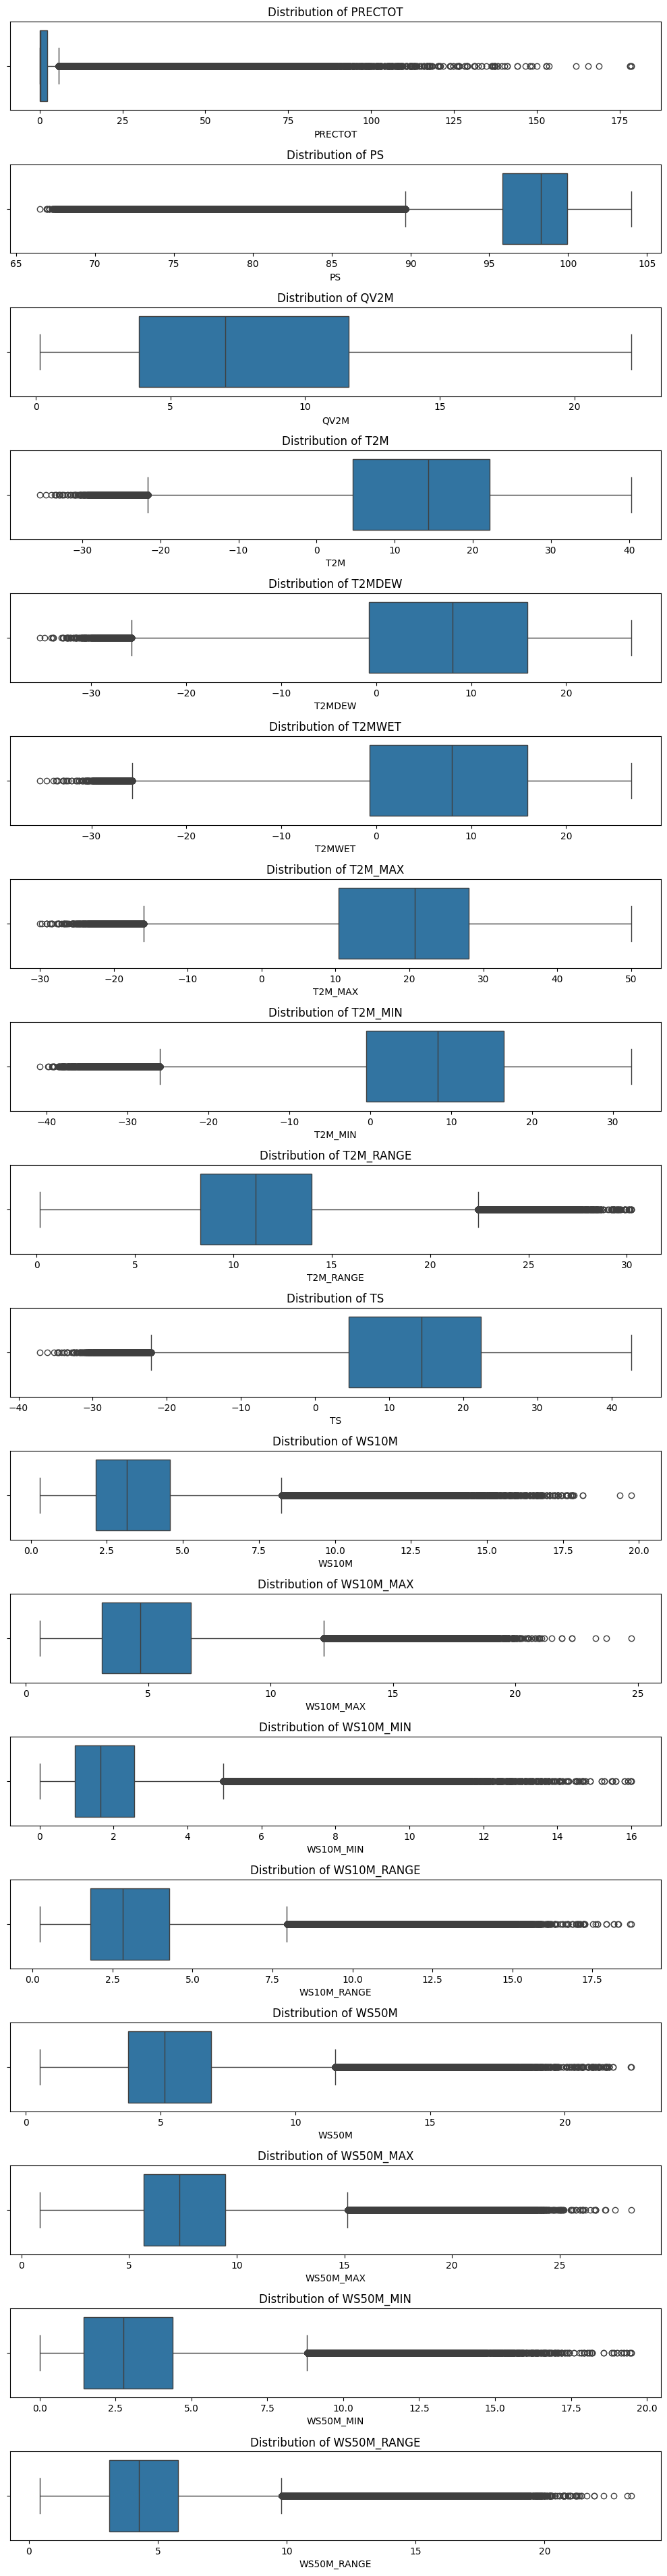

In [17]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  drought_df_measures.columns[x-1], data=drought_df_measures)
    x_name = drought_df_measures.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()

In [18]:
# Three Standard Deviations Rule (3-sigma Rule)
# Any data point greater than 𝜇+3𝜎 or less than μ−3σ is considered an outlier

print('Total rows = ', len(drought_df_measures.index))
print("{:<70} {:>10}".format('\nColumn Name', 'Outliers'))  # Print header

for i in drought_df_measures.select_dtypes(exclude=['object']).columns:
    num = len(drought_df_measures[
        (drought_df_measures[i] > drought_df_measures[i].mean() + 3 * drought_df_measures[i].std()) | 
        (drought_df_measures[i] < drought_df_measures[i].mean() - 3 * drought_df_measures[i].std())
    ])
    print("{:<70} {:>10}".format(f'Number of values beyond the standard outlier limit in {i} is:', num))


Total rows =  3403260

Column Name                                                             Outliers
Number of values beyond the standard outlier limit in PRECTOT is:           80854
Number of values beyond the standard outlier limit in PS is:                90414
Number of values beyond the standard outlier limit in QV2M is:                  0
Number of values beyond the standard outlier limit in T2M is:                5649
Number of values beyond the standard outlier limit in T2MDEW is:             2589
Number of values beyond the standard outlier limit in T2MWET is:             2164
Number of values beyond the standard outlier limit in T2M_MAX is:            4381
Number of values beyond the standard outlier limit in T2M_MIN is:            8148
Number of values beyond the standard outlier limit in T2M_RANGE is:          4496
Number of values beyond the standard outlier limit in TS is:                 5921
Number of values beyond the standard outlier limit in WS10M is:             

In [19]:
# Function to filter outliers based on the 3-sigma rule
def remove_outliers(df, columns):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        upper_limit = mean + 3 * std
        lower_limit = mean - 3 * std
        df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]
    return df

# Remove outliers
cleaned_drought_df_measures = remove_outliers(drought_df_measures, measures)

# Print the number of rows before and after removing outliers
print(f'Total rows before removing outliers: {len(drought_df_measures)}')
print(f'Total rows after removing outliers: {len(cleaned_drought_df_measures)}')
print(f'Number of outliers: {len(drought_df_measures)-len(cleaned_drought_df_measures)}')


Total rows before removing outliers: 3403260
Total rows after removing outliers: 3054658
Number of outliers: 348602


#### Distribution of categorical variables

In [20]:
categorical = ['score','year','month','day']
drought_categorical = drought_df[categorical]

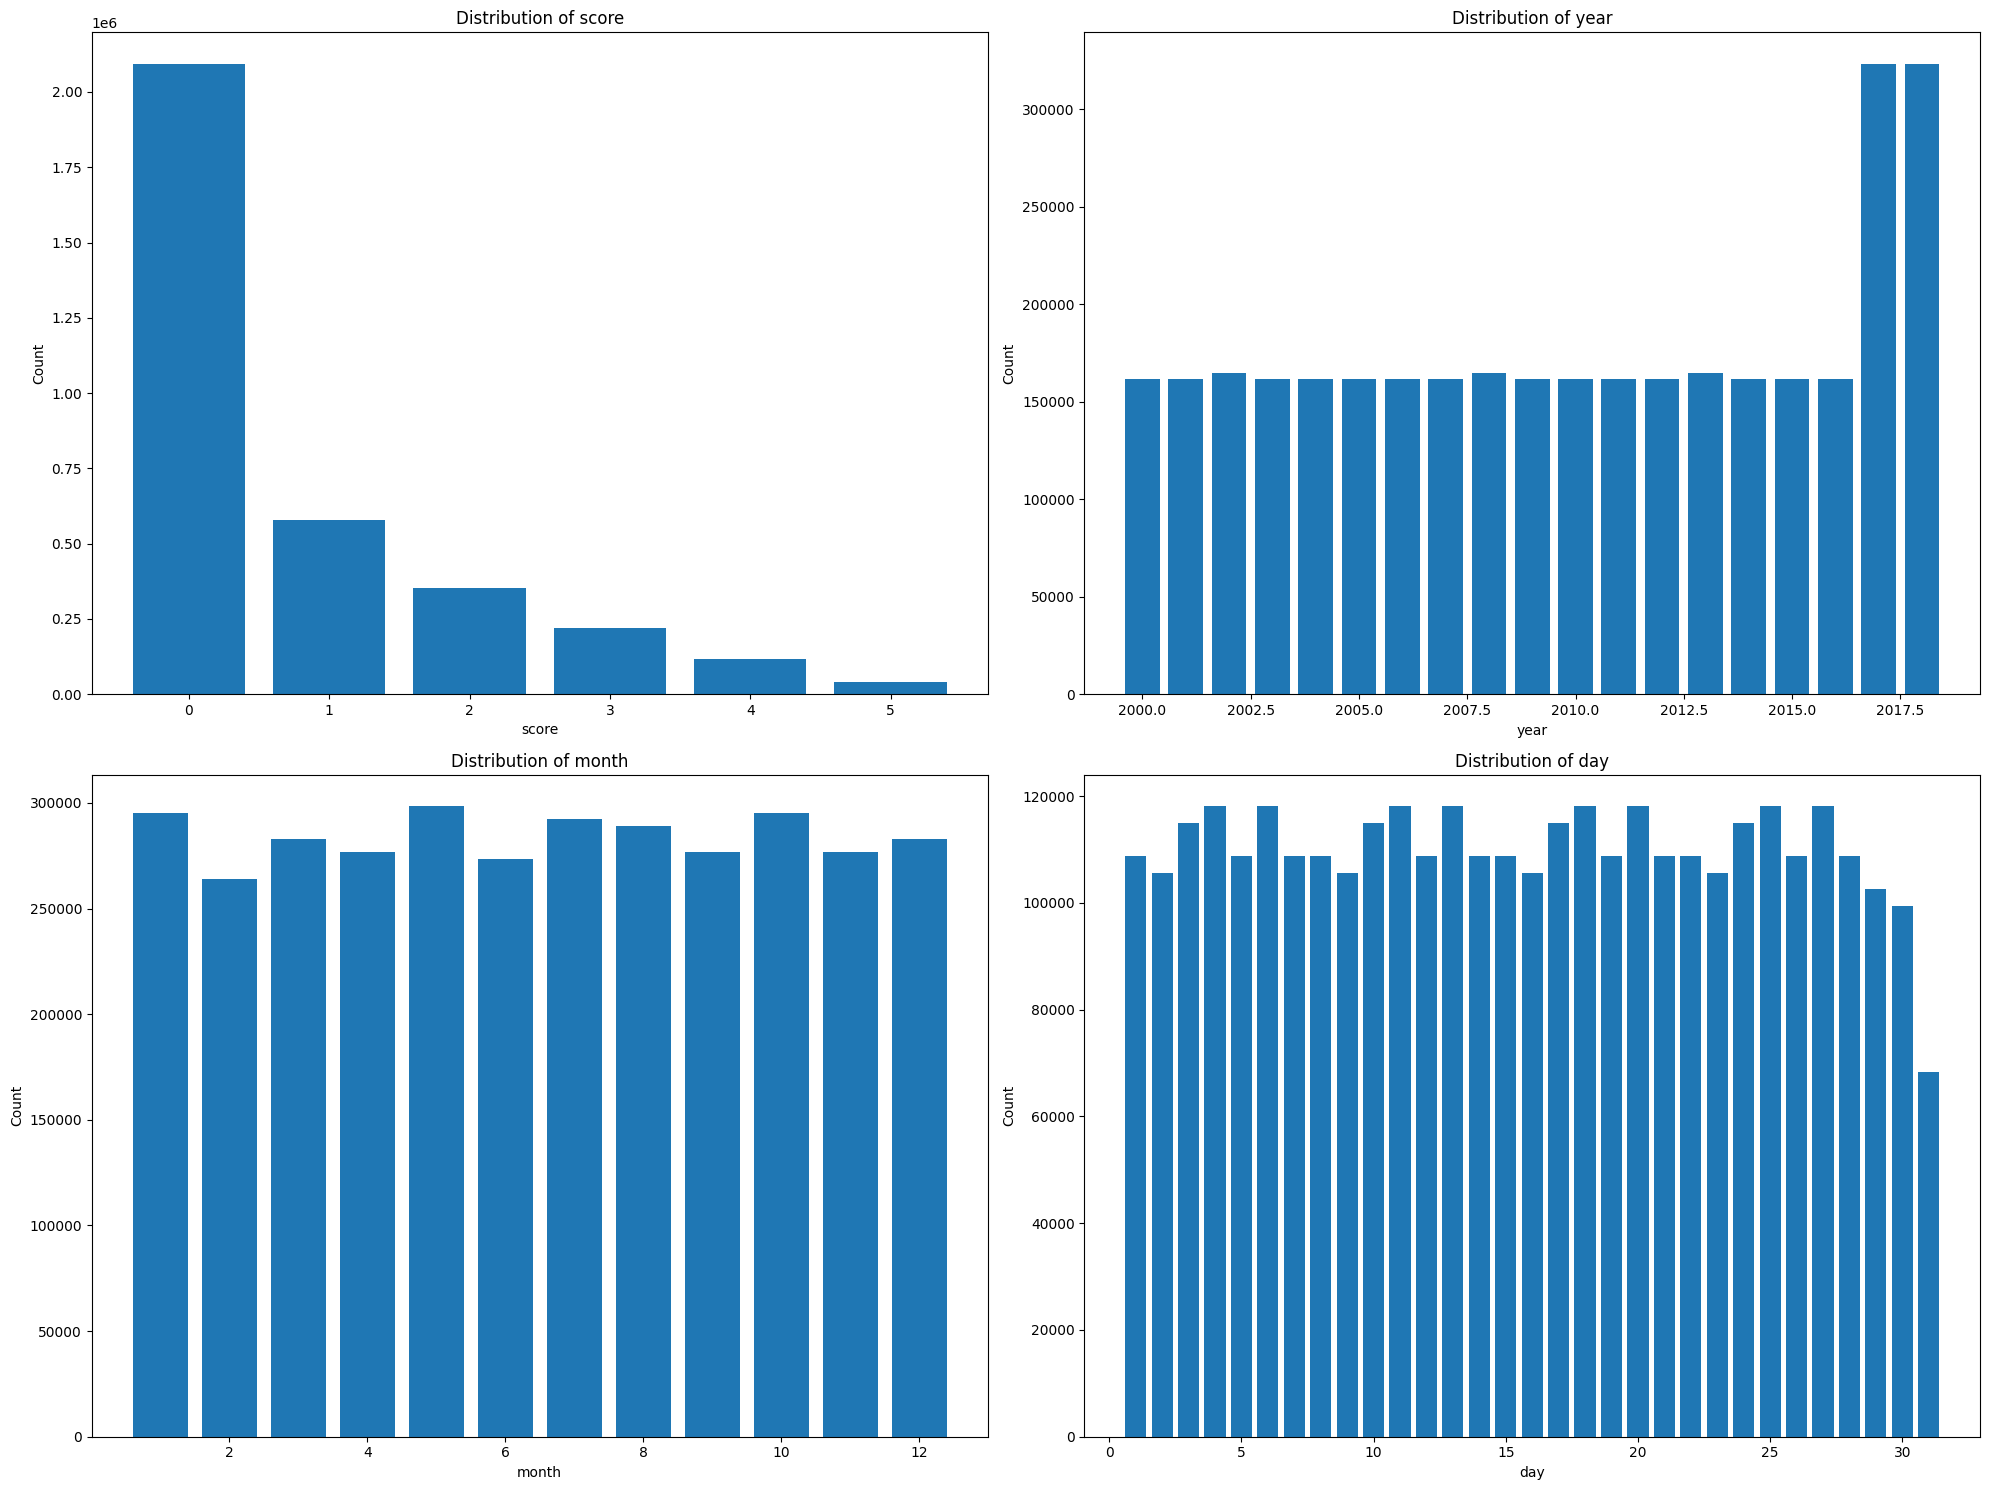

In [21]:
# Calculate number of rows and columns needed
n_measures = len(categorical)
n_cols = 2  # Number of columns
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot bar charts
for ax, col_name in zip(axes, categorical):
    ax.bar(drought_categorical[col_name].value_counts().index, drought_categorical[col_name].value_counts().values)  
    ax.set_xlabel(col_name)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col_name}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


#### Correlation

In [22]:
correlati_plot = drought_df_measures.corr()
correlati_plot.style.background_gradient(cmap='coolwarm')


,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
PRECTOT,1.000000,0.070030,0.246913,0.098108,0.233058,0.232971,0.031924,0.148720,-0.301812,0.094613,0.050756,0.061878,0.023471,0.067020,0.068471,0.078519,0.056302,0.048127
PS,0.070030,1.000000,0.284979,0.166492,0.342553,0.342854,0.114063,0.210599,-0.228937,0.166094,-0.076533,-0.131189,0.025855,-0.194386,-0.038578,-0.087301,0.039750,-0.152658
QV2M,0.246913,0.284979,1.000000,0.873016,0.959256,0.960861,0.807776,0.908187,-0.076827,0.865432,-0.234358,-0.263592,-0.118249,-0.272872,-0.215658,-0.258928,-0.089876,-0.251497
T2M,0.098108,0.166492,0.873016,1.000000,0.915222,0.915924,0.983423,0.981708,0.234725,0.997510,-0.216632,-0.226795,-0.134891,-0.211852,-0.202700,-0.215222,-0.120265,-0.164908
T2MDEW,0.233058,0.342553,0.959256,0.915222,1.000000,0.999897,0.857273,0.940396,-0.019460,0.906958,-0.245806,-0.273921,-0.124984,-0.282110,-0.211792,-0.251809,-0.089908,-0.242158
T2MWET,0.232971,0.342854,0.960861,0.915924,0.999897,1.000000,0.857841,0.941310,-0.020243,0.907707,-0.245848,-0.273951,-0.125142,-0.282041,-0.212211,-0.252215,-0.090227,-0.242379
T2M_MAX,0.031924,0.114063,0.807776,0.983423,0.857273,0.857841,1.000000,0.938077,0.398040,0.980195,-0.224932,-0.227758,-0.150656,-0.202246,-0.204664,-0.204505,-0.140219,-0.131566
T2M_MIN,0.148720,0.210599,0.908187,0.981708,0.940396,0.941310,0.938077,1.000000,0.055591,0.979203,-0.215945,-0.233246,-0.122900,-0.228826,-0.208277,-0.235373,-0.104761,-0.206277
T2M_RANGE,-0.301812,-0.228937,-0.076827,0.234725,-0.019460,-0.020243,0.398040,0.055591,1.000000,0.232055,-0.076446,-0.038776,-0.108763,0.023048,-0.038337,0.033873,-0.126714,0.167047
TS,0.094613,0.166094,0.865432,0.997510,0.906958,0.907707,0.980195,0.979203,0.232055,1.000000,-0.198834,-0.209553,-0.119974,-0.198971,-0.190531,-0.202416,-0.110346,-0.157773


Attributes QV2M, T2M, T2MDEW, T2MWET, T2M_MAX, T2M_MIN and TS have shown strong positive correlation  
Similary WS10M, WS10M_MAX and WS10M_MIN have shown a strong positve correlation  
Likewise, WS50M, WS50M_MAX and WS50M_MIN show strong positive correlation  
However, from the scatter plots above, we see significant variance between the data points, despite the strong positive correlation. Hence we'll retain all these variables, and try other feature selection methods.

In [24]:
drought_df.to_csv('data/all_timeseries.csv', encoding='utf-8', index=False)

# Soil Data

In [24]:
soil_df = pd.read_csv('data/soil_data.csv')
soil_df.head()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,...,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,...,1.891909,0.027488,1.919397,3,2,1,1,1,1,1


#### Initial exploration 

In [25]:
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fips           3109 non-null   int64  
 1   lat            3109 non-null   float64
 2   lon            3109 non-null   float64
 3   elevation      3109 non-null   int64  
 4   slope1         3109 non-null   float64
 5   slope2         3109 non-null   float64
 6   slope3         3109 non-null   float64
 7   slope4         3109 non-null   float64
 8   slope5         3109 non-null   float64
 9   slope6         3109 non-null   float64
 10  slope7         3109 non-null   float64
 11  slope8         3109 non-null   float64
 12  aspectN        3109 non-null   float64
 13  aspectE        3109 non-null   float64
 14  aspectS        3109 non-null   float64
 15  aspectW        3109 non-null   float64
 16  aspectUnknown  3109 non-null   float64
 17  WAT_LAND       3109 non-null   float64
 18  NVG_LAND

In [26]:
soil_df.isnull().sum()

fips             0
lat              0
lon              0
elevation        0
slope1           0
slope2           0
slope3           0
slope4           0
slope5           0
slope6           0
slope7           0
slope8           0
aspectN          0
aspectE          0
aspectS          0
aspectW          0
aspectUnknown    0
WAT_LAND         0
NVG_LAND         0
URB_LAND         0
GRS_LAND         0
FOR_LAND         0
CULTRF_LAND      0
CULTIR_LAND      0
CULT_LAND        0
SQ1              0
SQ2              0
SQ3              0
SQ4              0
SQ5              0
SQ6              0
SQ7              0
dtype: int64

#### Removing missing values

#### Format Data

In [28]:
soil_df.dtypes

fips               int64
lat              float64
lon              float64
elevation          int64
slope1           float64
slope2           float64
slope3           float64
slope4           float64
slope5           float64
slope6           float64
slope7           float64
slope8           float64
aspectN          float64
aspectE          float64
aspectS          float64
aspectW          float64
aspectUnknown    float64
WAT_LAND         float64
NVG_LAND         float64
URB_LAND         float64
GRS_LAND         float64
FOR_LAND         float64
CULTRF_LAND      float64
CULTIR_LAND      float64
CULT_LAND        float64
SQ1                int64
SQ2                int64
SQ3                int64
SQ4                int64
SQ5                int64
SQ6                int64
SQ7                int64
dtype: object

In [29]:
soil_df['fips'].nunique()

3109

## EDA

In [32]:
soil_df.columns

Index(['fips', 'lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3',
       'slope4', 'slope5', 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE',
       'aspectS', 'aspectW', 'aspectUnknown', 'WAT_LAND', 'NVG_LAND',
       'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND',
       'CULT_LAND', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7'],
      dtype='object')

#### Distribution of continuous variables

In [33]:
measures = list(soil_df.columns)

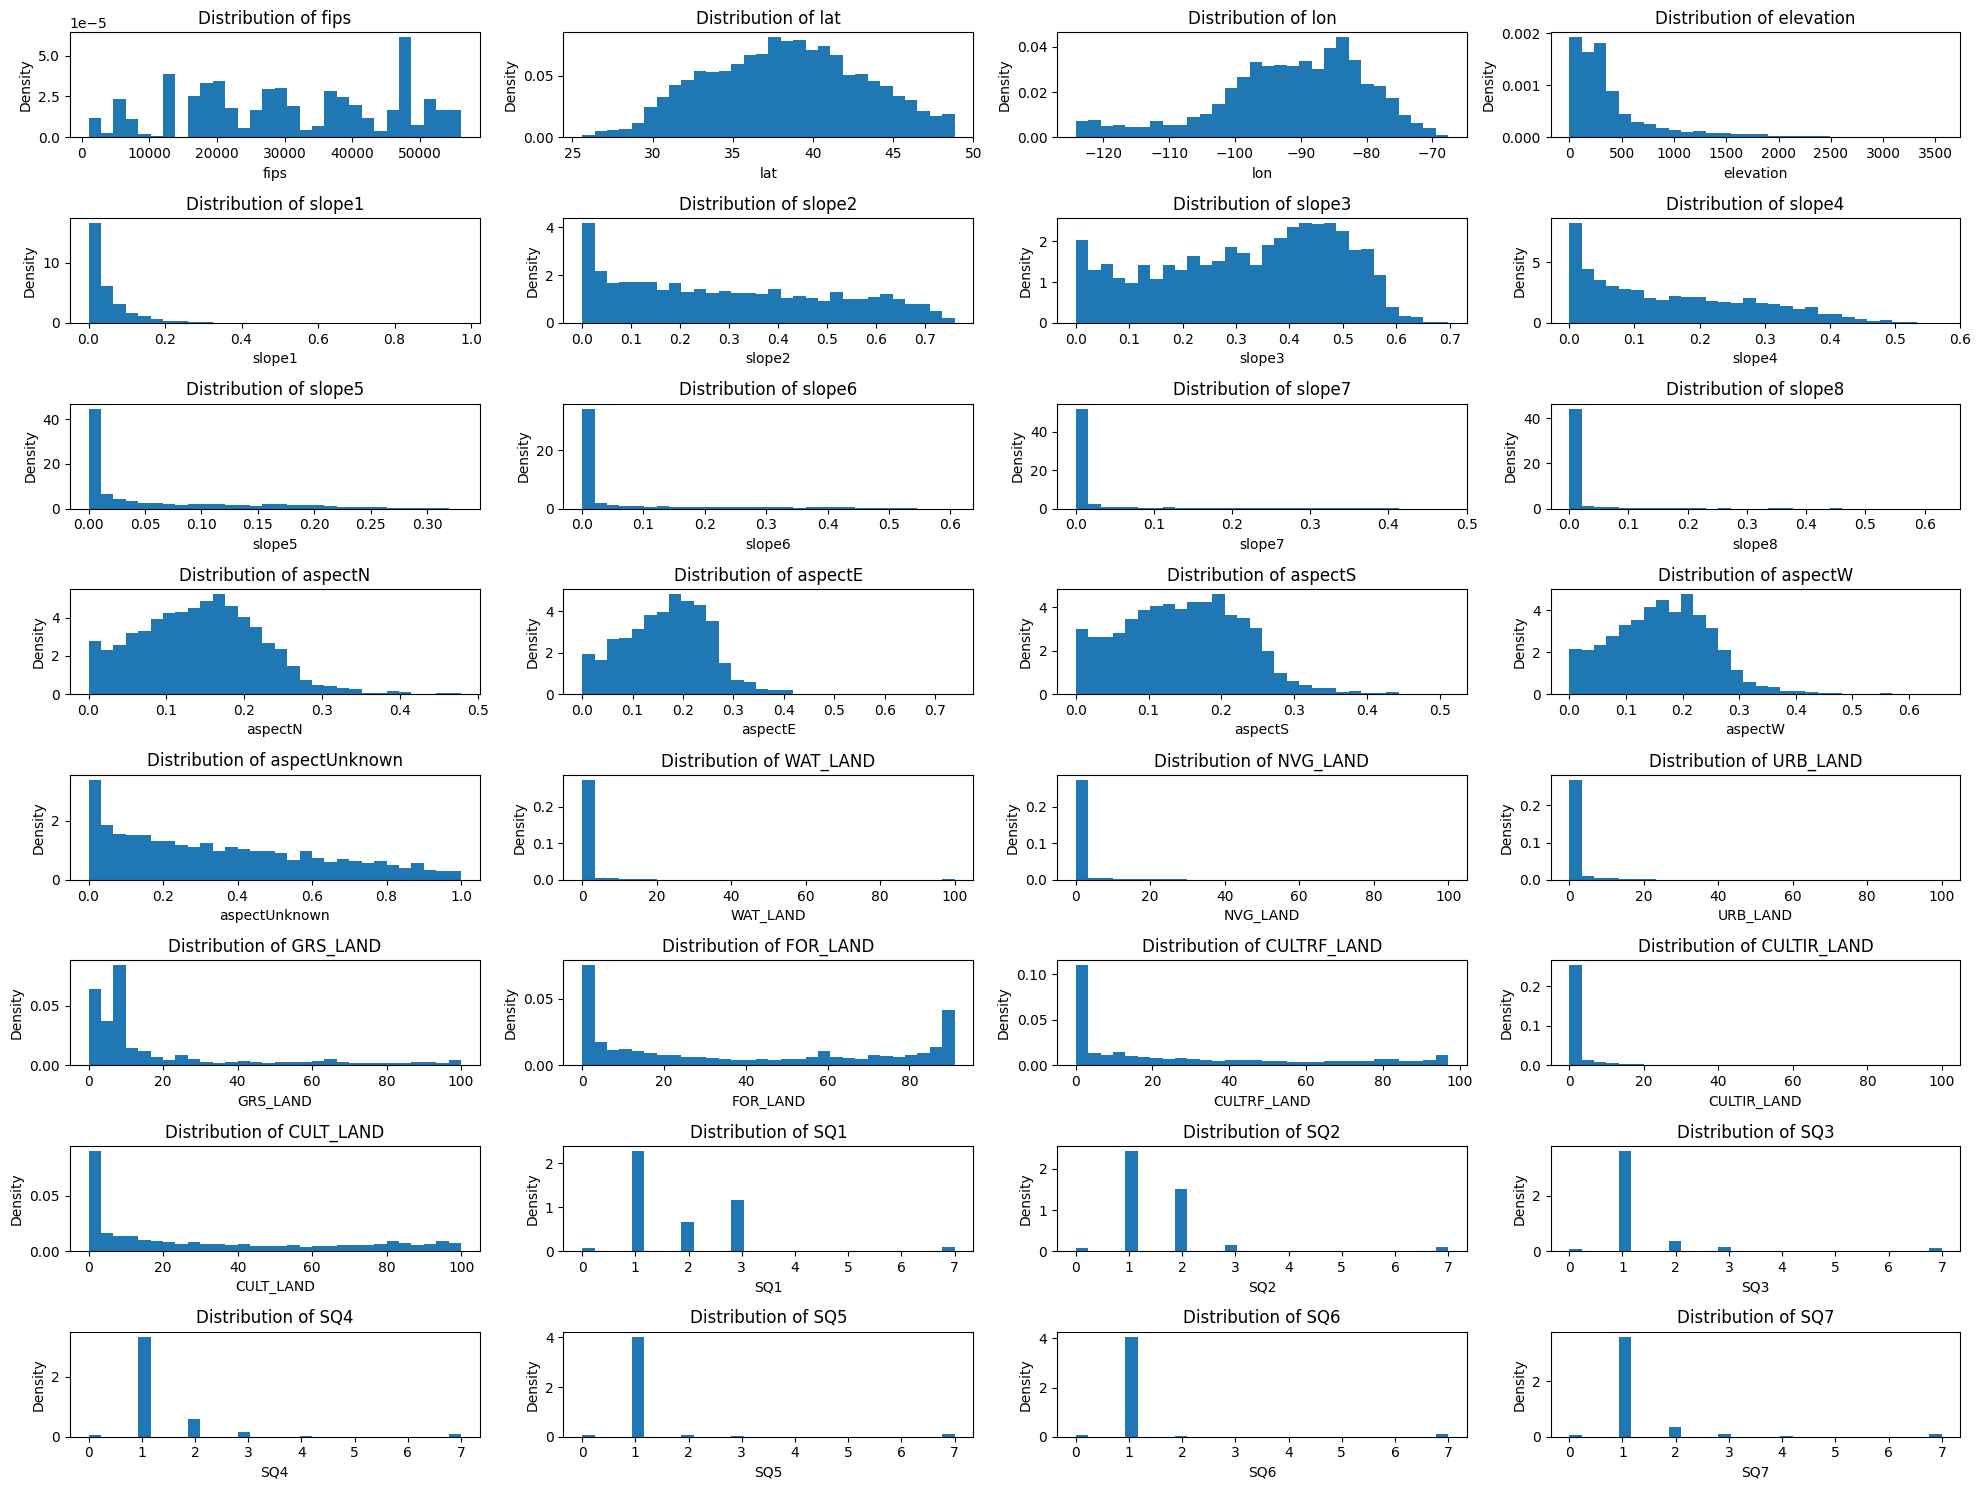

In [34]:
# Calculate number of rows and columns needed
n_measures = len(list(soil_df.columns))
n_cols = 4  # Number of columns
n_rows = (n_measures + n_cols - 1) // n_cols  # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot histograms 
for ax, col_name in zip(axes, measures):
    ax.hist(soil_df[col_name], bins=30, density=True)  
    ax.set_xlabel(col_name)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {col_name}')

# Remove any empty subplots
for i in range(len(measures), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Identifying outliers

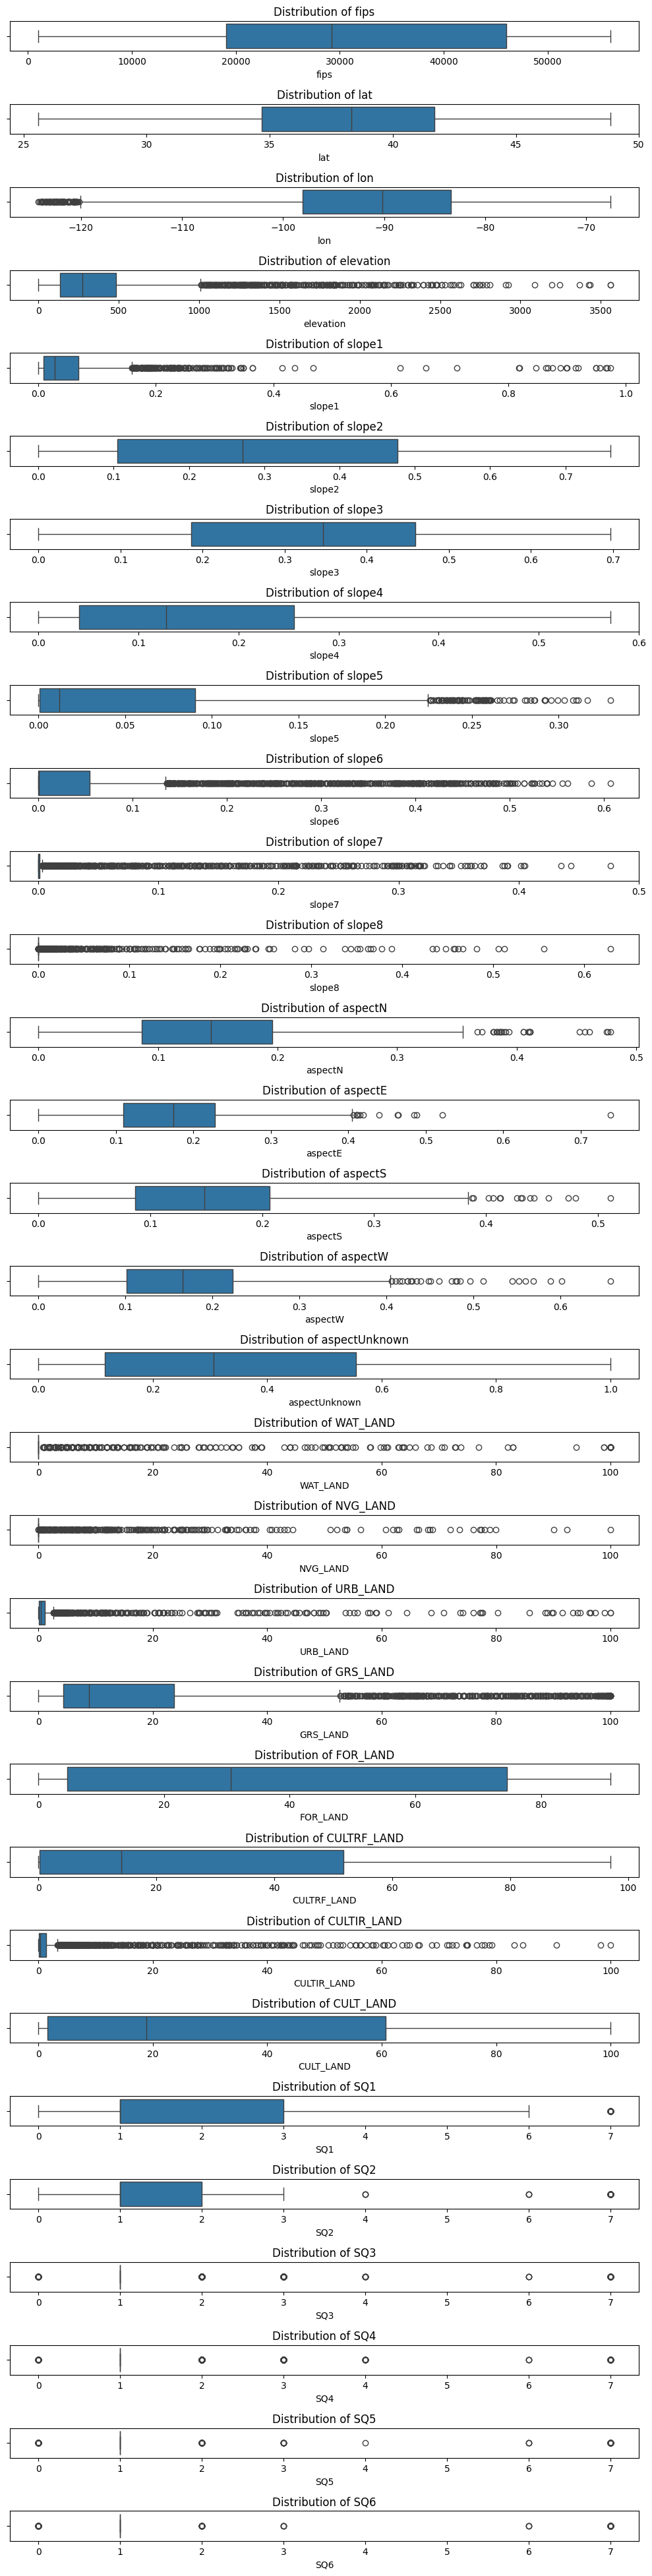

In [35]:
plt.figure(figsize=(10,40))
for x in (range(1,n_measures)):
    plt.subplot(n_measures,1,x)
    sns.boxplot(x =  soil_df.columns[x-1], data=soil_df)
    x_name = soil_df.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()

In [36]:
# Three Standard Deviations Rule (3-sigma Rule)
# Any data point greater than 𝜇+3𝜎 or less than μ−3σ is considered an outlier

print('Total rows = ', len(soil_df.index))
print("{:<70} {:>10}".format('\nColumn Name', 'Outliers'))  # Print header

for i in soil_df.select_dtypes(exclude=['object']).columns:
    num = len(soil_df[
        (soil_df[i] > soil_df[i].mean() + 3 * soil_df[i].std()) | 
        (soil_df[i] < soil_df[i].mean() - 3 * soil_df[i].std())
    ])
    print("{:<70} {:>10}".format(f'Number of values beyond the standard outlier limit in {i} is:', num))


Total rows =  3109

Column Name                                                             Outliers
Number of values beyond the standard outlier limit in fips is:                  0
Number of values beyond the standard outlier limit in lat is:                   0
Number of values beyond the standard outlier limit in lon is:                   0
Number of values beyond the standard outlier limit in elevation is:            81
Number of values beyond the standard outlier limit in slope1 is:               32
Number of values beyond the standard outlier limit in slope2 is:                0
Number of values beyond the standard outlier limit in slope3 is:                0
Number of values beyond the standard outlier limit in slope4 is:                2
Number of values beyond the standard outlier limit in slope5 is:               19
Number of values beyond the standard outlier limit in slope6 is:               75
Number of values beyond the standard outlier limit in slope7 is:              1

#### Correlation

In [37]:
correlati_plot = soil_df.corr()
correlati_plot.style.background_gradient(cmap='coolwarm')


,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
fips,1.000000,0.141720,0.045691,0.022712,-0.088054,-0.087765,-0.057167,0.040767,0.123539,0.107777,0.041839,0.005800,0.081486,0.088695,0.039819,0.046054,-0.098708,0.044484,0.045084,-0.001901,0.194387,-0.016963,-0.121496,-0.132603,-0.158097,-0.017240,0.005680,0.066245,-0.016776,0.035201,0.040918,0.090037
lat,0.141720,1.000000,-0.191780,0.257240,-0.088313,-0.105148,-0.181138,0.047746,0.153122,0.147524,0.135165,0.134304,0.073646,0.067069,0.023391,0.077867,-0.112585,0.078509,-0.040908,-0.000334,-0.052962,-0.120859,0.184056,-0.047166,0.162384,-0.159647,-0.062781,0.054674,-0.020927,0.081287,0.076371,0.029304
lon,0.045691,-0.191780,1.000000,-0.587908,0.010025,-0.065378,0.126007,0.148091,0.028012,-0.121056,-0.230887,-0.271016,-0.042761,0.001258,0.050997,-0.010582,-0.048561,0.091383,-0.317266,0.148520,-0.479292,0.283082,0.098236,-0.208375,0.029711,0.371908,0.289533,-0.010185,0.113267,0.014252,0.037463,-0.001469
elevation,0.022712,0.257240,-0.587908,1.000000,-0.153941,-0.200518,-0.229315,0.030974,0.240310,0.369687,0.418110,0.404943,0.273889,0.251052,0.172214,0.202772,-0.209922,-0.133629,0.306414,-0.113525,0.447502,-0.058347,-0.258030,0.054937,-0.231126,-0.239488,-0.191861,0.068919,-0.175559,-0.013576,-0.042161,0.034569
slope1,-0.088054,-0.088313,0.010025,-0.153941,1.000000,0.499065,-0.287921,-0.472032,-0.365974,-0.288559,-0.201974,-0.121614,-0.566011,-0.585208,-0.573076,-0.566201,0.726152,-0.019458,0.014850,-0.025368,-0.025486,-0.224590,0.203613,0.197136,0.257152,-0.154673,-0.098163,-0.088496,0.162605,-0.035740,-0.037501,-0.064636
slope2,-0.087765,-0.105148,-0.065378,-0.200518,0.499065,1.000000,0.097368,-0.698141,-0.699293,-0.598646,-0.437240,-0.268203,-0.725276,-0.702654,-0.747638,-0.710805,0.958190,-0.078235,0.051176,0.014950,0.110167,-0.509682,0.384549,0.294405,0.461441,-0.300609,-0.247439,-0.195793,0.097042,-0.095058,-0.101610,-0.163182
slope3,-0.057167,-0.181138,0.126007,-0.229315,-0.287921,0.097368,1.000000,0.197135,-0.444015,-0.594044,-0.513643,-0.336100,0.090236,0.170397,0.084352,0.109891,-0.017817,-0.161589,-0.044549,0.073788,0.066945,-0.112325,0.190478,-0.085484,0.156648,-0.017596,-0.095245,-0.217630,-0.150161,-0.140609,-0.143814,-0.225782
slope4,0.040767,0.047746,0.148091,0.030974,-0.472032,-0.698141,0.197135,1.000000,0.606168,0.157749,-0.077251,-0.110020,0.632874,0.657072,0.670331,0.635966,-0.709768,-0.136836,-0.042522,0.015583,-0.057273,0.370877,-0.189334,-0.194066,-0.242462,0.160659,0.066565,-0.046866,-0.240076,-0.092981,-0.090770,-0.069667
slope5,0.123539,0.153122,0.028012,0.240310,-0.365974,-0.699293,-0.444015,0.606168,1.000000,0.754304,0.344492,0.108520,0.596356,0.562653,0.630056,0.596563,-0.675663,-0.104040,-0.005421,-0.030669,-0.054633,0.481311,-0.340418,-0.161919,-0.377799,0.107865,0.067932,0.055413,-0.199623,-0.067937,-0.065965,0.039228
slope6,0.107777,0.147524,-0.121056,0.369687,-0.288559,-0.598646,-0.594044,0.157749,0.754304,1.000000,0.753072,0.360260,0.519258,0.451888,0.526893,0.499449,-0.570247,-0.087434,0.007634,-0.054176,-0.039477,0.449287,-0.340876,-0.122280,-0.365916,0.052207,0.043666,0.102628,-0.154284,-0.051485,-0.048775,0.088735
